Matrices and vectors for thermal circuit from Figure 1
θss = [40. 40. 40. 40. 40. 40. 40. 40.] °C
θssQ = [0.05 0.15 0.25 2.24 4.23 8.23 2.39 3.16] °C
uss = [40 40 40 40  0  0  0  0]
yss = 40.00 °C
Error between DAE and state-space: 7.11e-15 °C
yssQ = 8.23 °C
Error between DAE and state-space: 1.78e-15 °C
Δtmax = 12723 s = 3.5 h
dt = 7200 s = 2.0 h
t_settle = 179328 s = 49.8 h
duration = 180000 s = 50.0 h


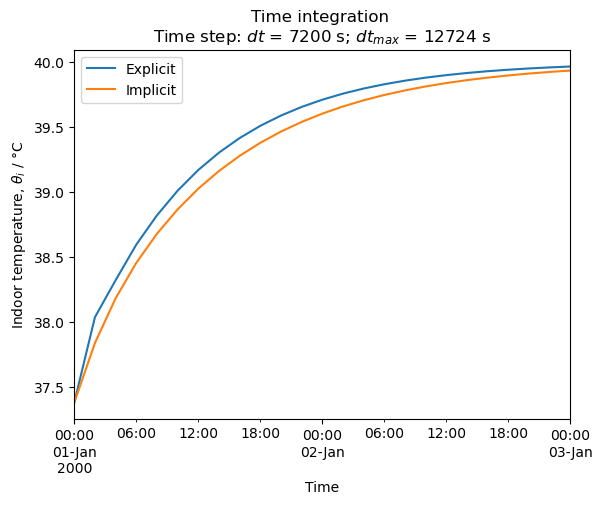

Steady-state indoor temperature obtained with:
- DAE model: 40.0000 °C
- state-space model: 40.0000 °C
- steady-state response to step input: 39.9644 °C


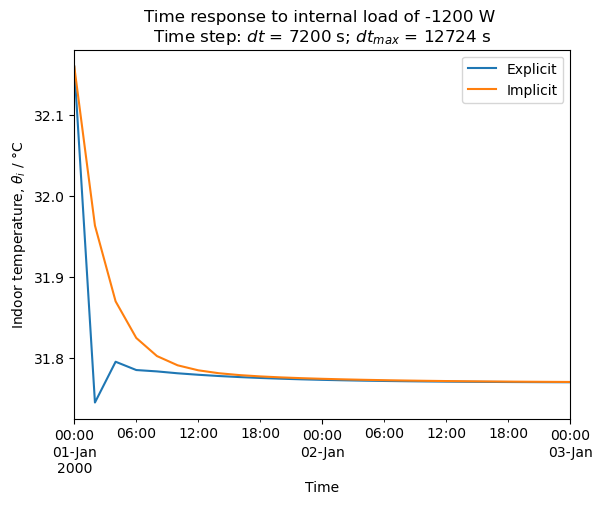

Steady-state indoor temperature obtained with:
- DAE model: 8.2308 °C
- state-space model: 8.2308 °C
- steady-state response to step input: 31.7696 °C


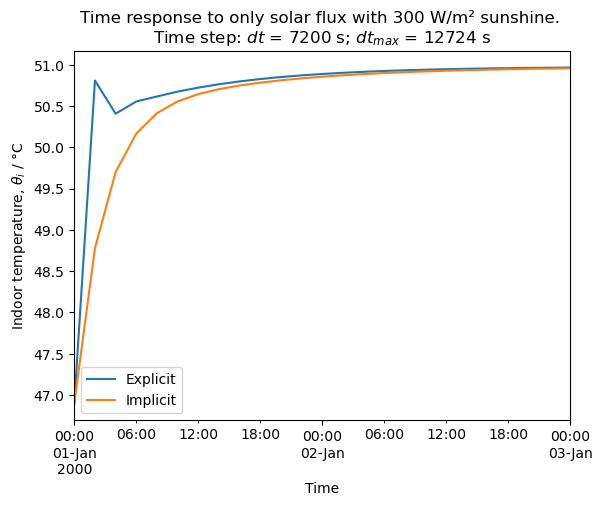

Steady-state indoor temperature obtained with:
- DAE model: 8.2308 °C
- state-space model: 8.2308 °C
- steady-state response to step input: 50.9646 °C


In [5]:
# -*- coding: utf-8 -*-
"""
Created on Mon Apr 14 11:26:56 2025

@author: taupiacs
"""

# librairy import

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import dm4bem

# initial values

To = 40
To_excel = To


controller = False
neglect_air_glass_capacity = True
imposed_time_step = False
# Δt = 498    # s, imposed time step // previous
Δt = 3336

print('Matrices and vectors for thermal circuit from Figure 1') 
# with computer of the school
# df = pd.read_csv(r'Z:\2A S2\Smart Cities\TC_steady.csv')

# with my computer
df = pd.read_csv('./toy_model/TC_steady.csv')

df.style.apply(lambda x: ['background-color: yellow'
                          if x.name in df.index[-3:] or c in df.columns[-2:]
                          else '' for c in df.columns], axis=1)

# MODEL
# =====
# Thermal circuit

# with computer of the school
# TC = dm4bem.file2TC(r'Z:\2A S2\Smart Cities\TC.csv', name='', auto_number=False)

# with my computer
TC = dm4bem.file2TC('./toy_model/TC_steady.csv', name='', auto_number=False)

# by default TC['G']['q11'] = 0, i.e. Kp -> 0, no controller (free-floating)

if neglect_air_glass_capacity:
    TC['C']['θ5'] = TC['C']['θ6'] = 0
    # or
    TC['C'].update({'θ5': 0, 'θ6': 0})
    
# State-space
[As, Bs, Cs, Ds, us] = dm4bem.tc2ss(TC)

bss = np.zeros(11)        # temperature sources b for steady state
bss[[0, 6, 7, 10]] = To      # outdoor temperature
# bss[[11]] = 25            # indoor set-point temperature 
# we don't have Tisp here

fss = np.zeros(8)         # flow-rate sources f for steady state

A = TC['A']
G = TC['G']
diag_G = pd.DataFrame(np.diag(G), index=G.index, columns=G.index)

θss = np.linalg.inv(A.T @ diag_G @ A) @ (A.T @ diag_G @ bss + fss)
print(f'θss = {np.around(θss, 2)} °C')

bss = np.zeros(11)        # temperature sources b for steady state

fss = np.zeros(8)         # flow-rate sources f for steady state
fss[[5]] = 1200

θssQ = np.linalg.inv(A.T @ diag_G @ A) @ (A.T @ diag_G @ bss + fss)
print(f'θssQ = {np.around(θssQ, 2)} °C')

bT = np.array([To, To, To, To])     # [To, To, To, Tisp] // now [To, To, To, To]
fQ = np.array([0, 0, 0, 0])         # [Φo, Φi, Qa, Φa]
uss = np.hstack([bT, fQ])           # input vector for state space
print(f'uss = {uss}')

inv_As = pd.DataFrame(np.linalg.inv(As),
                      columns=As.index, index=As.index)
yss = (-Cs @ inv_As @ Bs + Ds) @ uss

yss = float(yss.values[0])
print(f'yss = {yss:.2f} °C')

print(f'Error between DAE and state-space: {abs(θss[5] - yss):.2e} °C')

bT = np.array([0, 0, 0, 0])         # [To, To, To, Tisp] // now [To, To, To, To]
fQ = np.array([0, 0, 1200, 0])      # [Φo, Φi, Qa, Φa]
uss = np.hstack([bT, fQ])

inv_As = pd.DataFrame(np.linalg.inv(As),
                      columns=As.index, index=As.index)
yssQ = (-Cs @ inv_As @ Bs + Ds) @ uss

yssQ = float(yssQ.values[0])
print(f'yssQ = {yssQ:.2f} °C')

print(f'Error between DAE and state-space: {abs(θssQ[5] - yssQ):.2e} °C')

# Eigenvalues analysis
λ = np.linalg.eig(As)[0]        # eigenvalues of matrix As

# time step
Δtmax = 2 * min(-1. / λ)    # max time step for stability of Euler explicit
dm4bem.print_rounded_time('Δtmax', Δtmax)

if imposed_time_step:
    dt = Δt
else:
    dt = dm4bem.round_time(Δtmax)
dm4bem.print_rounded_time('dt', dt)

if dt < 10:
    raise ValueError("Time step is too small. Stopping the script.")
    
# settling time
t_settle = 4 * max(-1 / λ)
dm4bem.print_rounded_time('t_settle', t_settle)

# duration: next multiple of 3600 s that is larger than t_settle
duration = np.ceil(t_settle / 3600) * 3600
dm4bem.print_rounded_time('duration', duration)




### Time integration

# Create input_data_set
# ---------------------
# time vector
n = int(np.floor(duration / dt))    # number of time steps

# DateTimeIndex starting at "00:00:00" with a time step of dt
time = pd.date_range(start="2000-01-01 00:00:00",
                           periods=n, freq=f"{int(dt)}s")


# To = 10 * np.ones(n)        # outdoor temperature // previous
To_excel = To * np.ones(n)
# Ti_sp = 20 * np.ones(n)     # indoor temperature set point // no more Tisp
Φa = 0 * np.ones(n)         # solar radiation absorbed by the glass
Qa = Φo = Φi = Φa           # auxiliary heat sources and solar radiation

# data = {'To': To, 'Ti_sp': Ti_sp, 'Φo': Φo, 'Φi': Φi, 'Qa': Qa, 'Φa': Φa} // previous
data = {'To_excel': To_excel, 'Φo': Φo, 'Φi': Φi, 'Qa': Qa, 'Φa': Φa}

input_data_set = pd.DataFrame(data, index=time)

# inputs in time from input_data_set
u = dm4bem.inputs_in_time(us, input_data_set)

# Initial conditions
θ_exp = pd.DataFrame(index=u.index)     # empty df with index for explicit Euler
θ_imp = pd.DataFrame(index=u.index)     # empty df with index for implicit Euler

θ0 = 25                    # initial temperatures
θ_exp[As.columns] = θ0      # fill θ for Euler explicit with initial values θ0
θ_imp[As.columns] = θ0      # fill θ for Euler implicit with initial values θ0

I = np.eye(As.shape[0])     # identity matrix
for k in range(u.shape[0] - 1):
    θ_exp.iloc[k + 1] = (I + dt * As)\
        @ θ_exp.iloc[k] + dt * Bs @ u.iloc[k]
    θ_imp.iloc[k + 1] = np.linalg.inv(I - dt * As)\
        @ (θ_imp.iloc[k] + dt * Bs @ u.iloc[k])
        
# outputs
y_exp = (Cs @ θ_exp.T + Ds @  u.T).T
y_imp = (Cs @ θ_imp.T + Ds @  u.T).T

# plot results
y = pd.concat([y_exp, y_imp], axis=1, keys=['Explicit', 'Implicit'])
# Flatten the two-level column labels into a single level
y.columns = y.columns.get_level_values(0)

ax = y.plot()
ax.set_xlabel('Time')
ax.set_ylabel('Indoor temperature, $\\theta_i$ / °C')
ax.set_title(f'Time integration \nTime step: $dt$ = {dt:.0f} s; $dt_{{max}}$ = {Δtmax:.0f} s')
plt.show()

print('Steady-state indoor temperature obtained with:')
print(f'- DAE model: {float(θss[5]):.4f} °C')
print(f'- state-space model: {float(yss):.4f} °C')
print(f'- steady-state response to step input: \
{y_exp["θ5"].tail(1).values[0]:.4f} °C')






### Step response to internal load

# Create input_data_set
# ---------------------
# time vector
n = int(np.floor(duration / dt))    # number of time steps

# Create a DateTimeIndex starting at "00:00:00" with a time step of dt
time = pd.date_range(start="2000-01-01 00:00:00",
                            periods=n, freq=f"{int(dt)}s")
# Create input_data_set
# To = 0 * np.ones(n)         # outdoor temperature // previous
To_excel = To * np.ones(n)
# Ti_sp =  20 * np.ones(n)     # indoor temperature set point
Φa = 0 * np.ones(n)         # solar radiation absorbed by the glass
Φo = Φi = Φa                # solar radiation
Qa = -1200 * np.ones(n)      # auxiliary heat sources
# data = {'To': To, 'Ti_sp': Ti_sp, 'Φo': Φo, 'Φi': Φi, 'Qa': Qa, 'Φa': Φa}
data = {'To_excel': To_excel, 'Φo': Φo, 'Φi': Φi, 'Qa': Qa, 'Φa': Φa}

input_data_set = pd.DataFrame(data, index=time)

# Get inputs in time from input_data_set
u = dm4bem.inputs_in_time(us, input_data_set)

# Initial conditions
θ0 = To
θ_exp[As.columns] = θ0      # fill θ for Euler explicit with initial values θ0
θ_imp[As.columns] = θ0      # fill θ for Euler implicit with initial values θ0

I = np.eye(As.shape[0])     # identity matrix
for k in range(u.shape[0] - 1):
    θ_exp.iloc[k + 1] = (I + dt * As)\
        @ θ_exp.iloc[k] + dt * Bs @ u.iloc[k]
    θ_imp.iloc[k + 1] = np.linalg.inv(I - dt * As)\
        @ (θ_imp.iloc[k] + dt * Bs @ u.iloc[k])

# outputs
y_exp = (Cs @ θ_exp.T + Ds @  u.T).T
y_imp = (Cs @ θ_imp.T + Ds @  u.T).T

# plot results
y = pd.concat([y_exp, y_imp], axis=1, keys=['Explicit', 'Implicit'])
# Flatten the two-level column labels into a single level
y.columns = y.columns.get_level_values(0)
ax = y.plot()
ax.set_xlabel('Time')
ax.set_ylabel('Indoor temperature, $\\theta_i$ / °C')
ax.set_title(f'Time response to internal load of {Qa[0]:.0f} W \nTime step: $dt$ = {dt:.0f} s; $dt_{{max}}$ = {Δtmax:.0f} s')
plt.show()

print('Steady-state indoor temperature obtained with:')
print(f'- DAE model: {float(θssQ[5]):.4f} °C')
print(f'- state-space model: {float(yssQ):.4f} °C')
print(f'- steady-state response to step input: \
{y_exp["θ5"].tail(1).values[0]:.4f} °C')





### Step response to only solar flux

!pip install ipynb
# values of Φo, Φi, Φa, Gsolar are calculated in modeling_toy_house file
from ipynb.fs.full.modeling_toy_house import Φo, Φi, Φa, Gsolar, To

# Create input_data_set
# ---------------------
# time vector
n = int(np.floor(duration / dt))    # number of time steps

# Create a DateTimeIndex starting at "00:00:00" with a time step of dt
time = pd.date_range(start="2000-01-01 00:00:00",
                            periods=n, freq=f"{int(dt)}s")
# Create input_data_set
# To = 0 * np.ones(n)         # outdoor temperature // previous
To_excel = To * np.ones(n)
# Ti_sp =  20 * np.ones(n)     # indoor temperature set point
phia = Φa * np.ones(n)         # solar radiation absorbed by the glass
phio = Φo * np.ones(n)
phii = Φi * np.ones(n)          
Qa = 0 * np.ones(n)      # auxiliary heat sources
# data = {'To': To, 'Ti_sp': Ti_sp, 'Φo': Φo, 'Φi': Φi, 'Qa': Qa, 'Φa': Φa}
data = {'To_excel': To_excel, 'Φo': phio, 'Φi': phii, 'Qa': Qa, 'Φa': phia}

input_data_set = pd.DataFrame(data, index=time)

# Get inputs in time from input_data_set
u = dm4bem.inputs_in_time(us, input_data_set)

# Initial conditions
θ0 = To
θ_exp[As.columns] = θ0      # fill θ for Euler explicit with initial values θ0
θ_imp[As.columns] = θ0      # fill θ for Euler implicit with initial values θ0

I = np.eye(As.shape[0])     # identity matrix
for k in range(u.shape[0] - 1):
    θ_exp.iloc[k + 1] = (I + dt * As)\
        @ θ_exp.iloc[k] + dt * Bs @ u.iloc[k]
    θ_imp.iloc[k + 1] = np.linalg.inv(I - dt * As)\
        @ (θ_imp.iloc[k] + dt * Bs @ u.iloc[k])

# outputs
y_exp = (Cs @ θ_exp.T + Ds @  u.T).T
y_imp = (Cs @ θ_imp.T + Ds @  u.T).T

# plot results
y = pd.concat([y_exp, y_imp], axis=1, keys=['Explicit', 'Implicit'])
# Flatten the two-level column labels into a single level
y.columns = y.columns.get_level_values(0)
ax = y.plot()
ax.set_xlabel('Time')
ax.set_ylabel('Indoor temperature, $\\theta_i$ / °C')
ax.set_title(f'Time response to only solar flux with {Gsolar:.0f} W/m² sunshine. \nTime step: $dt$ = {dt:.0f} s; $dt_{{max}}$ = {Δtmax:.0f} s')
plt.show()

print('Steady-state indoor temperature obtained with:')
print(f'- DAE model: {float(θssQ[5]):.4f} °C')
print(f'- state-space model: {float(yssQ):.4f} °C')
print(f'- steady-state response to step input: \
{y_exp["θ5"].tail(1).values[0]:.4f} °C')
